### Imports and load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
plt.rcParams["figure.figsize"] = (9, 5)

DATA = Path("../mimic_data/csv/merged_icd_notes_focused.csv.gz")
df = pd.read_csv(DATA)
df.head()

,subject_id,hadm_id,note_id,note_text,cleaned_text,n_codes,icd_codes,seq_nums,icd_codes_str,seq_nums_str,icd_versions,icd_long_titles,icd_long_titles_str
0,16925328,20000024,16925328-DS-6,\nName: ___ Unit No: ___\n \n...,[DISCHARGE_DIAGNOSIS]\nLaxative-induced diarrh...,1,['D500'],[1],D500,1,[10],['Iron deficiency anemia secondary to blood lo...,Iron deficiency anemia secondary to blood loss...
1,19430048,20000034,19430048-DS-12,\nName: ___ Unit No: __...,[DISCHARGE_DIAGNOSIS]\nPost-ERCP pain\n\n[HOSP...,1,['K831'],[1],K831,1,[10],['Obstruction of bile duct'],Obstruction of bile duct
2,14046553,20000094,14046553-DS-11,\nName: ___ Unit No: _...,[DISCHARGE_DIAGNOSIS]\nPATIENT DIED\n\n[CHIEF_...,1,['I509'],[1],I509,1,[10],"['Heart failure, unspecified']","Heart failure, unspecified"
3,14990224,20000147,14990224-DS-7,\nName: ___ Unit No: __...,[CHIEF_COMPLAINT]\nchest pain\n\n[HISTORY_OF_P...,1,['I213'],[1],I213,1,[10],['ST elevation (STEMI) myocardial infarction o...,ST elevation (STEMI) myocardial infarction of ...
4,13758099,20000239,13758099-DS-5,\nName: ___ Unit No: ___\n \nA...,[DISCHARGE_DIAGNOSIS]\nPRIMARY DIAGNOSIS\nChes...,1,['I120'],[1],I120,1,[10],['Hypertensive chronic kidney disease with sta...,Hypertensive chronic kidney disease with stage...


### Note Length Distribution

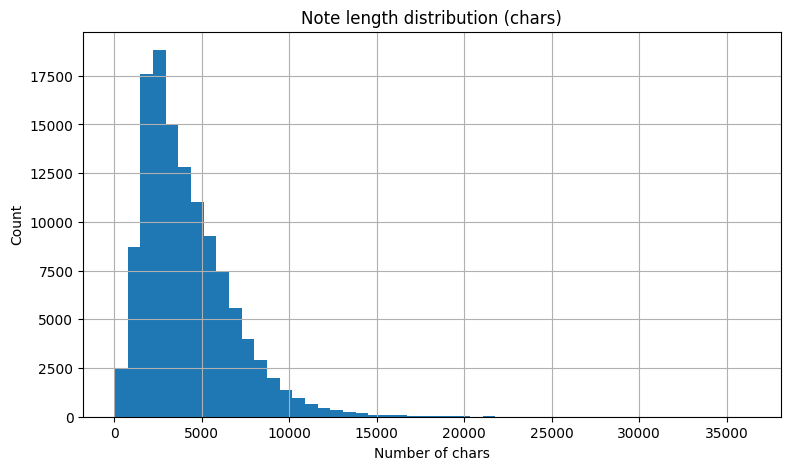

In [3]:
df["note_len_chars"] = df["cleaned_text"].astype(str).str.len()

ax = df["note_len_chars"].hist(bins=50)
ax.set_title("Note length distribution (chars)")
ax.set_xlabel("Number of chars"); ax.set_ylabel("Count")
plt.show()

### Chapter Distribution

Loaded 122,288 notes

📊 ICD-10 Chapter Distribution:
----------------------------------------------------
I    Circulatory System        :  24292 (19.86%)
K    Digestive System          :  17401 (14.23%)
S–T  Injury & Poisoning        :  14697 (12.02%)
C–D  Neoplasms & Blood         :  11299 ( 9.24%)
L–M  Skin & Musculoskeletal    :   8698 ( 7.11%)
A–B  Infectious & Parasitic    :   7394 ( 6.05%)
J    Respiratory System        :   7273 ( 5.95%)
N    Genitourinary             :   6050 ( 4.95%)
R    Symptoms & Abn. Findings  :   6007 ( 4.91%)
E    Endocrine & Metabolic     :   5015 ( 4.10%)
G    Nervous System            :   4382 ( 3.58%)
F    Mental & Behavioral       :   3632 ( 2.97%)
Z    Factors Influen. Health   :   3198 ( 2.62%)
O    Pregnancy & Childbirth    :   1892 ( 1.55%)
Q    Congenital & Chromosomal  :    538 ( 0.44%)
H    Eye & Ear                 :    518 ( 0.42%)
P    Perinatal Conditions      :      1 ( 0.00%)
V–Y  External Causes           :      1 ( 0.00%)
------------

C:\Users\1999j\AppData\Local\Temp\ipykernel_4632\1876760441.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=chapter_df.index, x=chapter_df["percent"], palette="viridis")


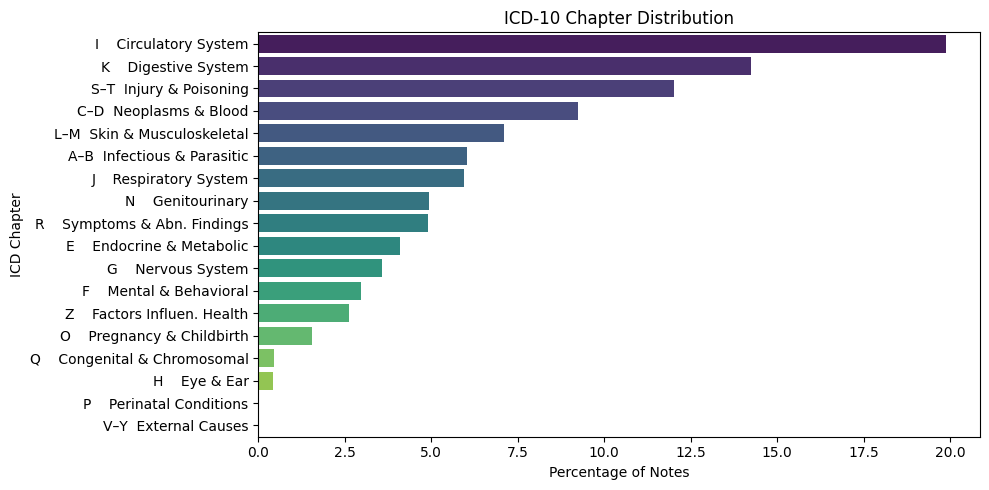

In [5]:

from collections import Counter
import seaborn as sns

# === Load data ===
DATA = Path("../mimic_data/csv/merged_icd_notes.csv.gz")
df = pd.read_csv(DATA)
print(f"Loaded {len(df):,} notes")

# === ICD → Chapter Mapping ===
def icd_to_chapter(icd_code: str) -> str:
    if not isinstance(icd_code, str) or len(icd_code) == 0:
        return "Unknown"
    letter = icd_code.strip()[0].upper()

    if letter in "AB": return "A–B  Infectious & Parasitic"
    if letter in "CD": return "C–D  Neoplasms & Blood"
    if letter == "E":  return "E    Endocrine & Metabolic"
    if letter == "F":  return "F    Mental & Behavioral"
    if letter == "G":  return "G    Nervous System"
    if letter == "H":  return "H    Eye & Ear"
    if letter == "I":  return "I    Circulatory System"
    if letter == "J":  return "J    Respiratory System"
    if letter == "K":  return "K    Digestive System"
    if letter in "LM": return "L–M  Skin & Musculoskeletal"
    if letter == "N":  return "N    Genitourinary"
    if letter == "O":  return "O    Pregnancy & Childbirth"
    if letter == "P":  return "P    Perinatal Conditions"
    if letter == "Q":  return "Q    Congenital & Chromosomal"
    if letter == "R":  return "R    Symptoms & Abn. Findings"
    if letter in "ST": return "S–T  Injury & Poisoning"
    if letter in "VWXY": return "V–Y  External Causes"
    if letter == "Z":  return "Z    Factors Influen. Health"
    if letter == "U":  return "U    Special Purposes"
    return "Other"

# === Extract ICD Code (string inside list-like text) ===
def extract_first_code(val):
    """Handles strings like "['D500']" → 'D500'"""
    if isinstance(val, str):
        val = val.strip()
        if val.startswith("[") and val.endswith("]"):
            val = val[1:-1]
        val = val.replace("'", "").replace('"', '').strip()
        if "," in val:  # multiple codes in string — take first
            val = val.split(",")[0].strip()
        return val
    return None

# Apply extraction + mapping
df["icd_code_clean"] = df["icd_codes"].apply(extract_first_code)
df["chapter"] = df["icd_code_clean"].apply(icd_to_chapter)

# === Count & Percentage ===
chapter_counts = Counter(df["chapter"])
total = sum(chapter_counts.values())

print("\n📊 ICD-10 Chapter Distribution:")
print("----------------------------------------------------")
for chap, count in sorted(chapter_counts.items(), key=lambda x: -x[1]):
    pct = 100 * count / total
    print(f"{chap:<30} : {count:>6} ({pct:5.2f}%)")
print("----------------------------------------------------")
print(f"Total notes: {total:,}\n")

# === Plot ===
plt.figure(figsize=(10,5))
chapter_df = (
    pd.DataFrame.from_dict(chapter_counts, orient="index", columns=["count"])
    .assign(percent=lambda d: 100 * d["count"] / d["count"].sum())
    .sort_values("count", ascending=False)
)
sns.barplot(y=chapter_df.index, x=chapter_df["percent"], palette="viridis")
plt.title("ICD-10 Chapter Distribution")
plt.xlabel("Percentage of Notes")
plt.ylabel("ICD Chapter")
plt.tight_layout()
plt.show()


### Basic Info

In [6]:
print("Rows:", len(df))
print(df.dtypes)
df.isna().mean().sort_values(ascending=False).head(20)

Rows: 122288
subject_id              int64
hadm_id                 int64
note_id                object
note_text              object
cleaned_text           object
n_codes                 int64
icd_codes              object
seq_nums               object
icd_codes_str          object
seq_nums_str            int64
icd_versions           object
icd_long_titles        object
icd_long_titles_str    object
icd_code_clean         object
chapter                object
dtype: object


cleaned_text           0.000131
hadm_id                0.000000
subject_id             0.000000
note_id                0.000000
note_text              0.000000
n_codes                0.000000
icd_codes              0.000000
seq_nums               0.000000
icd_codes_str          0.000000
seq_nums_str           0.000000
icd_versions           0.000000
icd_long_titles        0.000000
icd_long_titles_str    0.000000
icd_code_clean         0.000000
chapter                0.000000
dtype: float64

### Cleaned Text

In [8]:
print(df["cleaned_text"][0])

[DISCHARGE_DIAGNOSIS]
Laxative-induced diarrhea
Chronic anemia

[CHIEF_COMPLAINT]
weakness, diarrhea

[HISTORY_OF_PRESENT_ILLNESS]
Ms. [REDACTED] is a [REDACTED] year-old woman with PMH significant for
chronic anemia, osteoporosis, hypertension, ataxia, and recent
L5 fracture in the setting of recurrent falls who presents from
home with fatigue and generalized weakness and diarrhea.
 The patient's recent history is notable for the follow:
 - On [REDACTED], she presented with 4 days of LBP s/p fall from
standing at which time imaging revealed acute L5 fracture. She
was evaluated by Spine team who recommended early mobilization,
pain control, but no brace required. She was evaluated by [REDACTED],
and discharged to [REDACTED].
 - She was discharged home with [REDACTED] on [REDACTED].
 - On [REDACTED], she again presented to [REDACTED] s/p fall from
standing while trying to reach for a glass of water. She did
have a occipital scalp hematoma, but imaging including [REDACTED],
C-spine CT, a

### Explore ICD Codes & Frequency

In [9]:
codes_series = df["icd_codes_str"].dropna().astype(str).str.split(",")
codes_exploded = codes_series.explode().str.strip()
code_counts = codes_exploded.value_counts()
code_counts.head(20)

icd_codes_str
A419       3068
Z5111      2163
I214       1988
I130       1736
N179       1596
J189       1428
N390       1268
I110       1169
I2510       884
I25110      830
I350        824
T814XXA     792
J441        754
I2699       747
I671        683
R0789       602
R55         601
A4151       585
I5033       562
I5023       548
Name: count, dtype: int64

### Coverage@K

How many notes cover TOP 25, 50, 100... most frequent ICD codes?

In [10]:
def coverage_at_k(counts, k):
    counts = counts.values
    total = counts.sum()
    topk = counts[:k].sum()
    return topk / total if total > 0 else 0.0

coverage = {k: coverage_at_k(code_counts, k) for k in [10, 25, 50, 100, 200, 500]}
coverage


{10: np.float64(0.13190174015438963),
 25: np.float64(0.20531041475860265),
 50: np.float64(0.27946323433206854),
 100: np.float64(0.3808223210781107),
 200: np.float64(0.5093958524139736),
 500: np.float64(0.6838446944916917)}

### Top 50 Codes

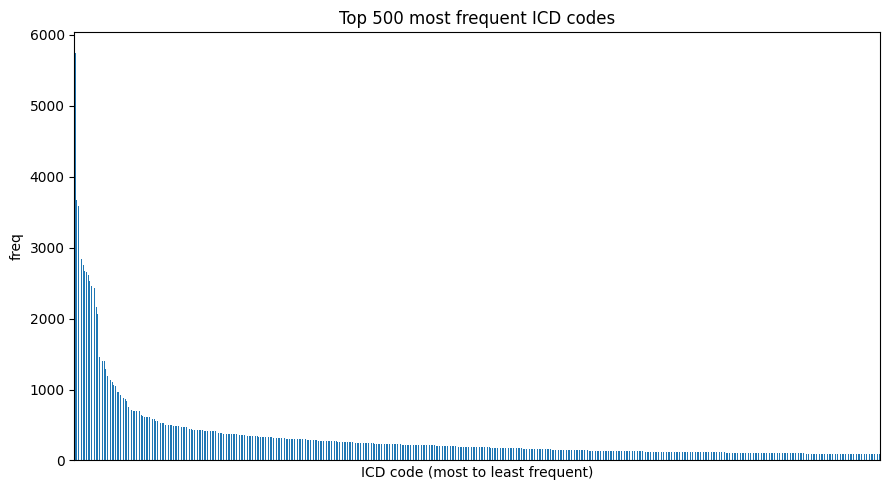

icd_codes_str
N179      5748
J189      3669
A419      3588
I10       3476
I5033     2837
          ... 
G8250       87
I6203       87
J95821      87
I9589       87
F10231      87
Name: count, Length: 500, dtype: int64


In [10]:
topk = 500
top_counts = code_counts.head(topk)
ax = top_counts.plot(kind="bar")
ax.set_title(f"Top {topk} most frequent ICD codes")
ax.set_xlabel("ICD code (most to least frequent)"); ax.set_ylabel("freq")
# Remove x-axis labels and ticks
ax.set_xticks([])

plt.tight_layout()
plt.show()
print(top_counts)

### How many codes to cover X% of data?

In [29]:
cum = code_counts.cumsum() / code_counts.sum()

def codes_to_cover(p):
    return int((cum <= p).sum())

for p in [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95]:
    print(f"Codes needed to cover {int(p*100)}%:", codes_to_cover(p))


Codes needed to cover 50%: 122
Codes needed to cover 60%: 213
Codes needed to cover 70%: 375
Codes needed to cover 75%: 501
Codes needed to cover 80%: 688
Codes needed to cover 90%: 1545
Codes needed to cover 95%: 2836
